# Measures of error in optic flow methods

Running deepflow_refframes.py on a video and specified set of reference frames will run DeepMatching to find a set of good correspondence points between each pair of ref frames. It will then run DeepFlow using these correspondences to seed/constrain the estimation. 

After this we can play around with different measures of the error in each flow estimation. We try a range of things below 

In [1]:
%matplotlib inline
import sys 
import argparse 
import os.path 
import os

import numpy as np 
from glob import glob 

from cvtools import readFlo

import matplotlib.pyplot as plt
import cv2 

threshold = 4
radius = 6

class Args:
	pass 
args = Args()

### Test data

In [2]:
args.dir_in = './register/test/'
r1 = 1; r2 = 2;

In [3]:
#Load DeepFlow data
print("Load DeepFlow between frame %d and %d" %(r1, r2))
fn_in1 = args.dir_in + 'corrmatrix/%04d_%04d.flo'%(r1, r2)
fn_in2 = args.dir_in + 'corrmatrix/%04d_%04d.flo'%(r2, r1)

flow1 = readFlo(fn_in1)
flow2 = readFlo(fn_in2)

nx = flow1.shape[0]
ny = flow1.shape[1]

#Flip x and y flow
flow1 = np.transpose(flow1, [1,0,2])
flow2 = np.transpose(flow2, [1,0,2])
flow1 = flow1[:,:,::-1]
flow2 = flow2[:,:,::-1]


Load DeepFlow between frame 1 and 2
Reading flo image
File longer than expected. Check format. Read file but proceed with caution
Reading flo image
File longer than expected. Check format. Read file but proceed with caution


First we perform the forward map, then the reverse map. We should get back to where we started. Thus large errors here indicate errors in the flow, or indicate difficult to specify parts of the image.

In [4]:
#Perform mapping and then reverse mapping, then perform reverse mapping then mapping
#Make mesh grid
fwdmeshy, fwdmeshx = [a.astype(np.float32) for a in np.meshgrid(np.arange(nx), np.arange(ny))]
revmeshy, revmeshx = [a.astype(np.float32) for a in np.meshgrid(np.arange(nx), np.arange(ny))]

#Perturb mesh grid by forward flow 
#Round to integers 
fwdx = fwdmeshx + np.ceil(flow1[:,:,0])
fwdy = fwdmeshy + np.ceil(flow1[:,:,1])

fwdx = np.maximum(0, np.minimum(nx-1, fwdx))
fwdy = np.maximum(0, np.minimum(nx-1, fwdy))

#Look up flow field using this perturbed map
fwdremapx = fwdx + flow2[fwdx.astype(int),fwdy.astype(int),0]
fwdremapy = fwdy + flow2[fwdx.astype(int),fwdy.astype(int),1]

fwdremapx -= fwdmeshx 
fwdremapy -= fwdmeshy 

fwderr = np.sqrt(fwdremapx**2 + fwdremapy**2)

[]

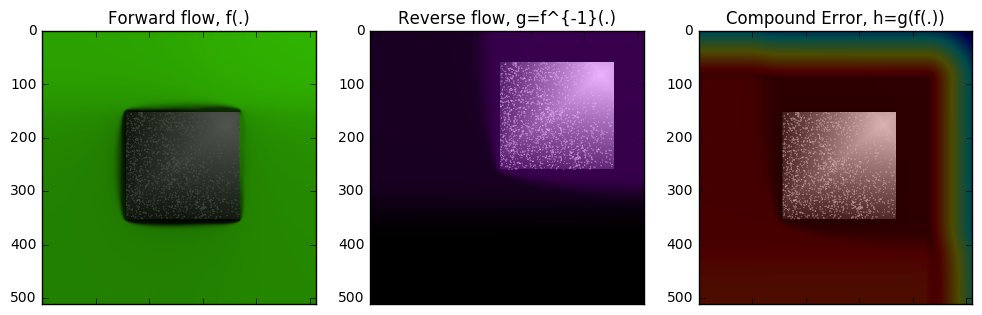

In [5]:
#Load reference frame
fn_in1 = args.dir_in + 'refframes/frame_%04d.png'%r1
rf1 = cv2.imread(fn_in1)
fn_in2 = args.dir_in + 'refframes/frame_%04d.png'%r2
rf2 = cv2.imread(fn_in2)

hsv = np.zeros_like(rf1)
hsv[...,1] = 255
mag, ang = cv2.cartToPolar(flow1[...,0], flow1[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
bgr1 = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
dst1 = cv2.addWeighted(rf1,0.3,bgr1,0.7,0)

hsv = np.zeros_like(rf2)
hsv[...,1] = 255
mag, ang = cv2.cartToPolar(flow2[...,0], flow2[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
bgr2 = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
dst2 = cv2.addWeighted(rf2,0.7,bgr2,0.3,0)

#Overlay with reference frame...
im_fwderr = cv2.normalize(fwderr, fwderr, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
im_fwderr = cv2.cvtColor(im_fwderr, cv2.COLOR_GRAY2BGR)
im_fwderr = cv2.applyColorMap(im_fwderr, cv2.COLORMAP_JET)
dst = cv2.addWeighted(rf1,0.7,im_fwderr,0.3,0)

fig_size = (12,9)
plt.rcParams["figure.figsize"] = fig_size

f, axes = plt.subplots(1,3)
p1 = axes[0].imshow(dst1)
p2 = axes[1].imshow(dst2)
p3 = axes[2].imshow(dst)
axes[0].set_title('Forward flow, f(.)')
axes[0].xaxis.set_ticklabels([])
axes[0].xaxis.set_ticklabels([])
axes[1].set_title('Reverse flow, g=f^{-1}(.)')
axes[1].xaxis.set_ticklabels([])
axes[1].xaxis.set_ticklabels([])
axes[2].set_title('Compound Error, h=g(f(.))')
axes[2].xaxis.set_ticklabels([])
axes[2].xaxis.set_ticklabels([])

The forward and reverse flow maps are roughly inverses of one another...with noticeable errors near the border where there is no image information

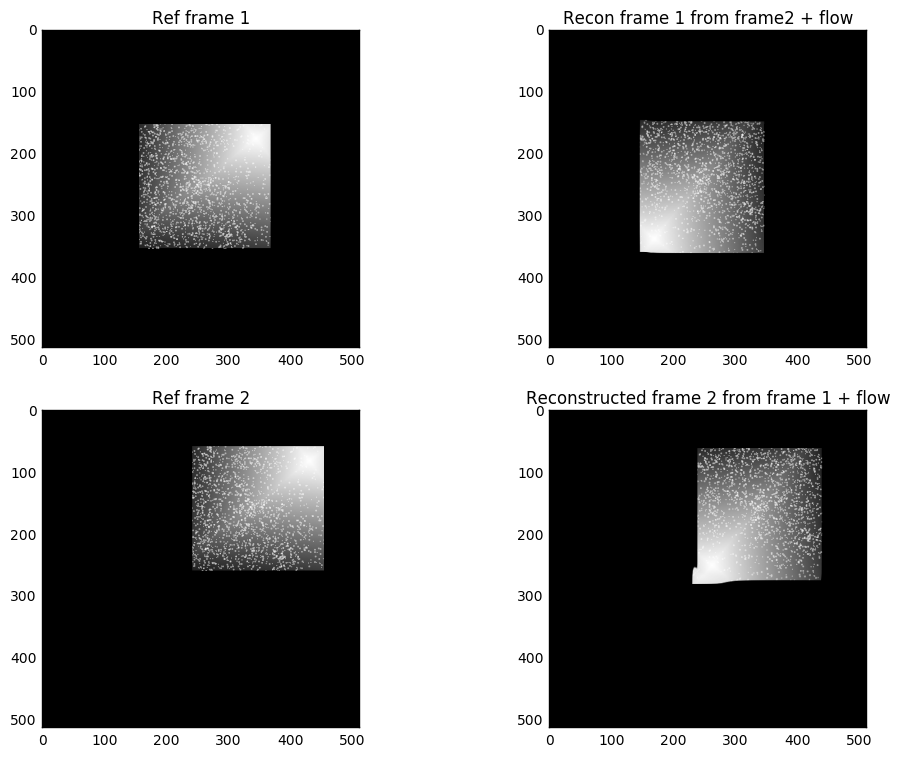

In [9]:
rf1_recon = cv2.remap(rf2, fwdmeshx - flow1[:,:,0], fwdmeshy - flow1[:,:,1], cv2.INTER_LINEAR)
rf2_recon = cv2.remap(rf1, revmeshx + flow2[:,:,0], revmeshy + flow2[:,:,1], cv2.INTER_LINEAR)

f, axes = plt.subplots(2,2)
axes[0,0].imshow(rf1)
axes[0,0].set_title('Ref frame 1')
axes[0,1].imshow(rf1_recon)
axes[0,1].set_title('Recon frame 1 from frame2 + flow')
axes[1,0].imshow(rf2)
axes[1,0].set_title('Ref frame 2')
axes[1,1].imshow(rf2_recon)
axes[1,1].set_title('Reconstructed frame 2 from frame 1 + flow')

The reconstructions look pretty good. 

Next let's compare measures of error for these reconstructions. 

In [10]:
#Run local comparisons within a window...
sim1cc = np.zeros((nx,ny))
sim2cc = np.zeros((nx,ny))
sim1l2 = np.zeros((nx,ny))
sim2l2 = np.zeros((nx,ny))
gr_rf1 = cv2.cvtColor(rf1, cv2.COLOR_BGR2GRAY)
gr_rf2 = cv2.cvtColor(rf2, cv2.COLOR_BGR2GRAY)
gr_rf1_rc = cv2.cvtColor(rf1_recon, cv2.COLOR_BGR2GRAY)
gr_rf2_rc = cv2.cvtColor(rf2_recon, cv2.COLOR_BGR2GRAY)


In [11]:
r2 = radius**2
for i in range(radius, nx-radius):
	for j in range(radius, ny-radius):
		#Generate window around current point
		pts1 = gr_rf1[i-radius:i+radius, j-radius:j+radius]
		pts2 = gr_rf1_rc[i-radius:i+radius, j-radius:j+radius]
		pts1 = np.reshape(pts1, (-1,1))
		pts2 = np.reshape(pts2, (-1,1))

		#Measure similiarty here
		l2 = np.sqrt(np.sum((pts1 - pts2)**2))/r2
		cc = np.corrcoef(pts1.T, pts2.T)[0,1]
		sim1cc[i,j] = cc if not np.isnan(cc) else 0
		sim1l2[i,j] = l2

		#Generate window around current point
		pts1 = gr_rf2[i-radius:i+radius, j-radius:j+radius]
		pts2 = gr_rf2_rc[i-radius:i+radius, j-radius:j+radius]
		pts1 = np.reshape(pts1, (-1,1))
		pts2 = np.reshape(pts2, (-1,1))
		#Measure similiarty here
		l2 = np.sqrt(np.sum((pts1 - pts2)**2))/r2
		cc = np.corrcoef(pts1.T, pts2.T)[0,1]
		sim2cc[i,j] = cc if not np.isnan(cc) else 0
		sim2l2[i,j] = l2

/Users/lansdell/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lansdell/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


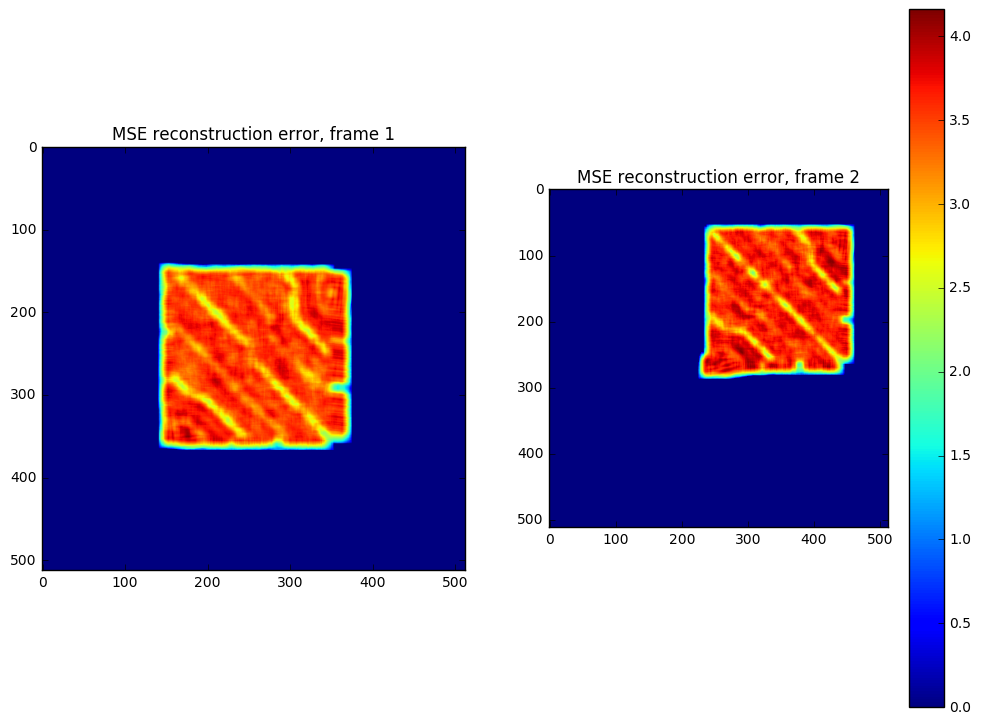

In [12]:
#Plot
f, axes = plt.subplots(1,2)
a= axes[0].imshow(sim1l2)
axes[1].imshow(sim2l2)
axes[0].set_title('MSE reconstruction error, frame 1')
axes[1].set_title('MSE reconstruction error, frame 2')
f.colorbar(a)


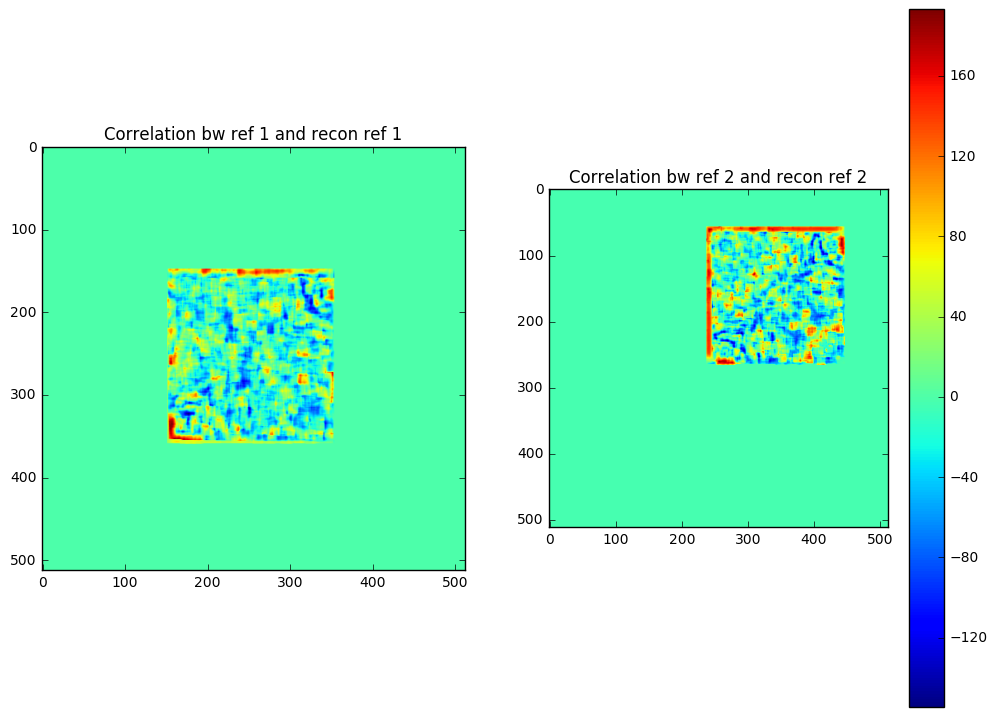

In [13]:
#Plot
f, axes = plt.subplots(1,2)
a=axes[0].imshow(sim1cc*255)
axes[1].imshow(sim2cc*255)
f.colorbar(a)
axes[0].set_title('Correlation bw ref 1 and recon ref 1')
axes[1].set_title('Correlation bw ref 2 and recon ref 2')

## Hydra test images

In [14]:
args.dir_in = './register/20160412stk0001/'
r1 = 120; r2 = 1;

In [15]:
#Load DeepFlow data
print("Load DeepFlow between frame %d and %d" %(r1, r2))
fn_in1 = args.dir_in + 'corrmatrix/%04d_%04d.flo'%(r1, r2)
fn_in2 = args.dir_in + 'corrmatrix/%04d_%04d.flo'%(r2, r1)

flow1 = readFlo(fn_in1)
flow2 = readFlo(fn_in2)

nx = flow1.shape[0]
ny = flow1.shape[1]

#Flip x and y flow
flow1 = np.transpose(flow1, [1,0,2])
flow2 = np.transpose(flow2, [1,0,2])
flow1 = flow1[:,:,::-1]
flow2 = flow2[:,:,::-1]


Load DeepFlow between frame 120 and 1
Reading flo image
File longer than expected. Check format. Read file but proceed with caution
Reading flo image
File longer than expected. Check format. Read file but proceed with caution


First we perform the forward map, then the reverse map. We should get back to where we started. Thus large errors here indicate errors in the flow, or indicate difficult to specify parts of the image.

In [18]:
#Perform mapping and then reverse mapping, then perform reverse mapping then mapping
#Make mesh grid
fwdmeshy, fwdmeshx = [a.astype(np.float32) for a in np.meshgrid(np.arange(nx), np.arange(ny))]
revmeshy, revmeshx = [a.astype(np.float32) for a in np.meshgrid(np.arange(nx), np.arange(ny))]

#Perturb mesh grid by forward flow 
#Round to integers 
fwdx = fwdmeshx + np.ceil(flow1[:,:,0])
fwdy = fwdmeshy + np.ceil(flow1[:,:,1])

fwdx = np.maximum(0, np.minimum(nx-1, fwdx))
fwdy = np.maximum(0, np.minimum(ny-1, fwdy))

#Look up flow field using this perturbed map
fwdremapx = fwdx + flow2[fwdx.astype(int),fwdy.astype(int),0]
fwdremapy = fwdy + flow2[fwdx.astype(int),fwdy.astype(int),1]

fwdremapx -= fwdmeshx 
fwdremapy -= fwdmeshy 

fwderr = np.sqrt(fwdremapx**2 + fwdremapy**2)

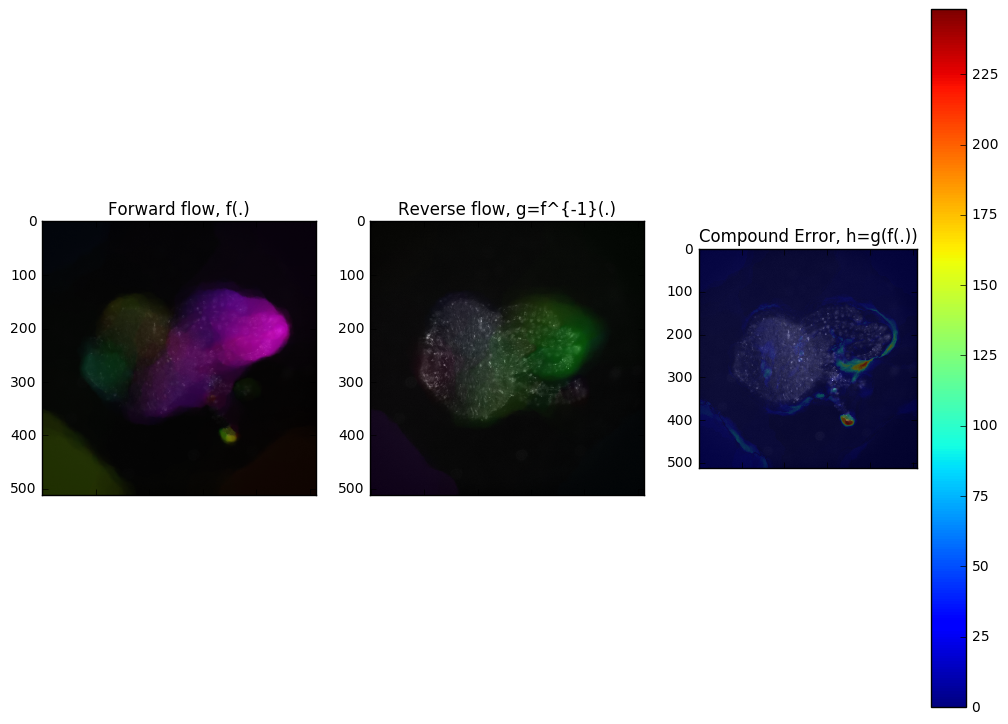

In [19]:
#Load reference frame
fn_in1 = args.dir_in + 'refframes/frame_%04d.png'%r1
rf1 = cv2.imread(fn_in1)
fn_in2 = args.dir_in + 'refframes/frame_%04d.png'%r2
rf2 = cv2.imread(fn_in2)

hsv = np.zeros_like(rf1)
hsv[...,1] = 255
mag, ang = cv2.cartToPolar(flow1[...,0], flow1[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
bgr1 = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
dst1 = cv2.addWeighted(rf1,0.3,bgr1,0.7,0)

hsv = np.zeros_like(rf2)
hsv[...,1] = 255
mag, ang = cv2.cartToPolar(flow2[...,0], flow2[...,1])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
bgr2 = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
dst2 = cv2.addWeighted(rf2,0.7,bgr2,0.3,0)

#Overlay with reference frame...
im_fwderr = cv2.normalize(fwderr, fwderr, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
im_fwderr = cv2.cvtColor(im_fwderr, cv2.COLOR_GRAY2RGB)
im_fwderr = cv2.applyColorMap(im_fwderr, cv2.COLORMAP_JET)
im_fwderr = cv2.cvtColor(im_fwderr, cv2.COLOR_RGB2BGR)
dst = cv2.addWeighted(rf1,0.7,im_fwderr,0.3,0)

fig_size = (12,9)
plt.rcParams["figure.figsize"] = fig_size

f, axes = plt.subplots(1,3)
p1 = axes[0].imshow(dst1)
p2 = axes[1].imshow(dst2)
p3 = axes[2].imshow(dst)
axes[0].set_title('Forward flow, f(.)')
axes[0].xaxis.set_ticklabels([])
axes[0].xaxis.set_ticklabels([])
axes[1].set_title('Reverse flow, g=f^{-1}(.)')
axes[1].xaxis.set_ticklabels([])
axes[1].xaxis.set_ticklabels([])
axes[2].set_title('Compound Error, h=g(f(.))')
axes[2].xaxis.set_ticklabels([])
axes[2].xaxis.set_ticklabels([])
plt.colorbar(p3)

The forward and reverse flow maps are roughly inverses of one another...with noticeable errors near the border where there is no image information

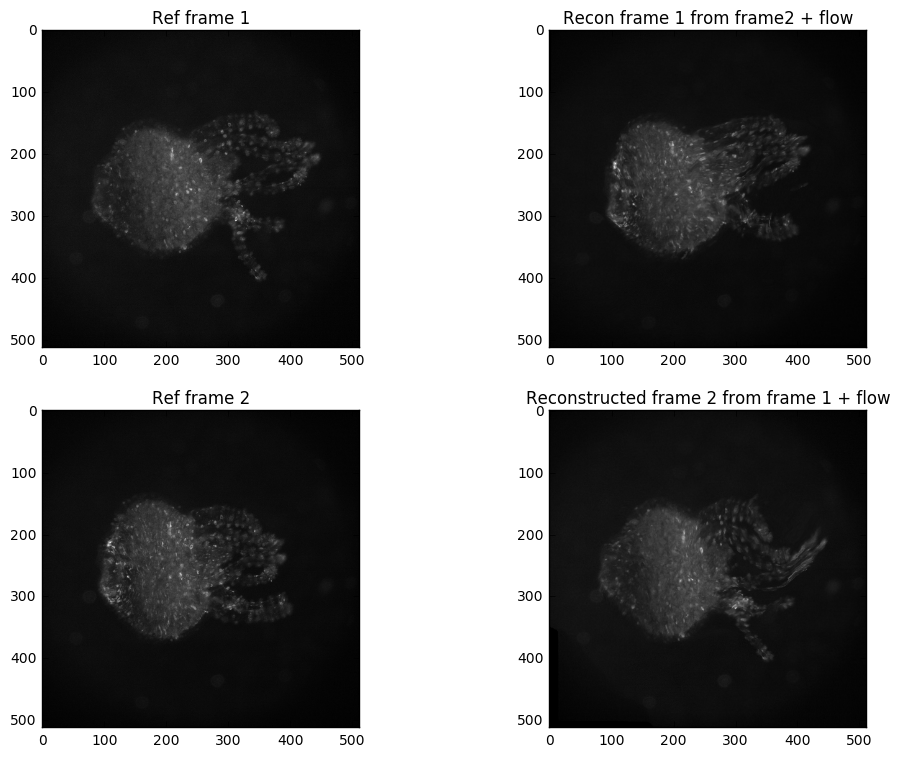

In [24]:
rf1_recon = cv2.remap(rf2, fwdmeshy - flow1[:,:,0], fwdmeshx - flow1[:,:,1], cv2.INTER_LINEAR)
rf2_recon = cv2.remap(rf1, revmeshy - flow2[:,:,0], revmeshx - flow2[:,:,1], cv2.INTER_LINEAR)

f, axes = plt.subplots(2,2)
axes[0,0].imshow(rf1)
axes[0,0].set_title('Ref frame 1')
axes[0,1].imshow(rf1_recon)
axes[0,1].set_title('Recon frame 1 from frame2 + flow')
axes[1,0].imshow(rf2)
axes[1,0].set_title('Ref frame 2')
axes[1,1].imshow(rf2_recon)
axes[1,1].set_title('Reconstructed frame 2 from frame 1 + flow')

The reconstructions look not so good this time. 

Next let's compare measures of error for these reconstructions. 

In [14]:
#Run local comparisons within a window...
sim1cc = np.zeros((nx,ny))
sim2cc = np.zeros((nx,ny))
sim1l2 = np.zeros((nx,ny))
sim2l2 = np.zeros((nx,ny))
gr_rf1 = cv2.cvtColor(rf1, cv2.COLOR_BGR2GRAY)
gr_rf2 = cv2.cvtColor(rf2, cv2.COLOR_BGR2GRAY)
gr_rf1_rc = cv2.cvtColor(rf1_recon, cv2.COLOR_BGR2GRAY)
gr_rf2_rc = cv2.cvtColor(rf2_recon, cv2.COLOR_BGR2GRAY)


In [17]:
r2 = radius**2
for i in range(radius, nx-radius):
	for j in range(radius, ny-radius):
		#Generate window around current point
		pts1 = gr_rf1[i-radius:i+radius, j-radius:j+radius]
		pts2 = gr_rf1_rc[i-radius:i+radius, j-radius:j+radius]
		pts1 = np.reshape(pts1, (-1,1))
		pts2 = np.reshape(pts2, (-1,1))
		#Measure similiarty here
		l2 = np.sqrt(np.sum((pts1 - pts2)**2))/r2
		cc = np.corrcoef(pts1.T, pts2.T)[0,1]
		sim1cc[i,j] = cc if not np.isnan(cc) else 0
		sim1l2[i,j] = l2
		#Generate window around current point
		pts1 = gr_rf2[i-radius:i+radius, j-radius:j+radius]
		pts2 = gr_rf2_rc[i-radius:i+radius, j-radius:j+radius]
		pts1 = np.reshape(pts1, (-1,1))
		pts2 = np.reshape(pts2, (-1,1))
		#Measure similiarty here
		l2 = np.sqrt(np.sum((pts1 - pts2)**2))/r2
		cc = np.corrcoef(pts1.T, pts2.T)[0,1]
		sim2cc[i,j] = cc if not np.isnan(cc) else 0
		sim2l2[i,j] = l2

/Users/lansdell/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lansdell/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


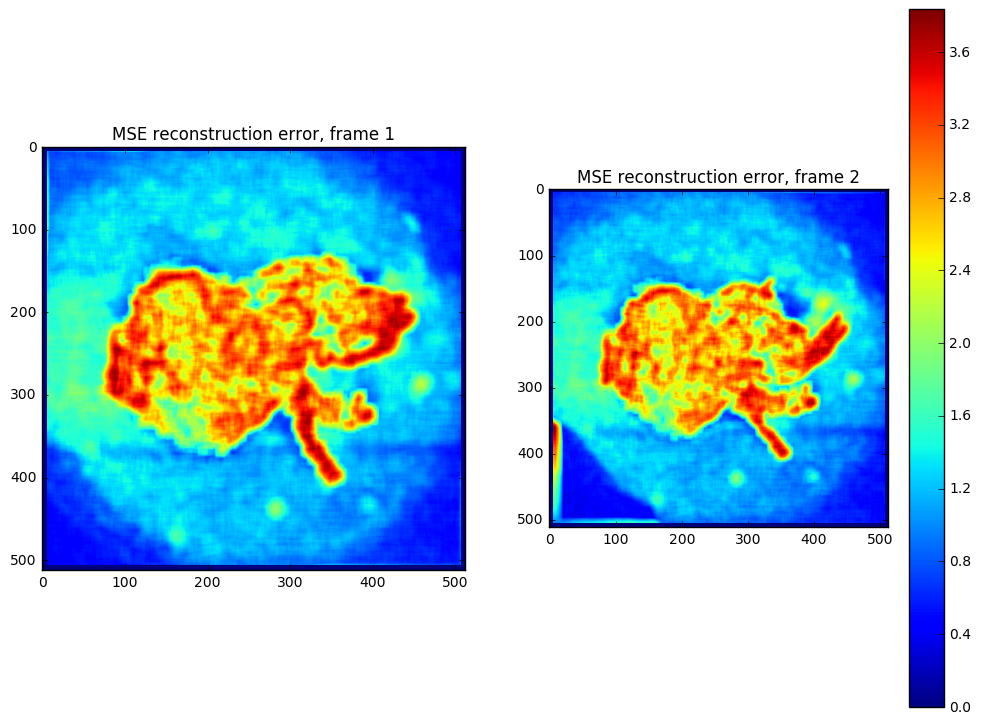

In [18]:
#Plot
f, axes = plt.subplots(1,2)
a= axes[0].imshow(sim1l2)
axes[1].imshow(sim2l2)
axes[0].set_title('MSE reconstruction error, frame 1')
axes[1].set_title('MSE reconstruction error, frame 2')
f.colorbar(a)


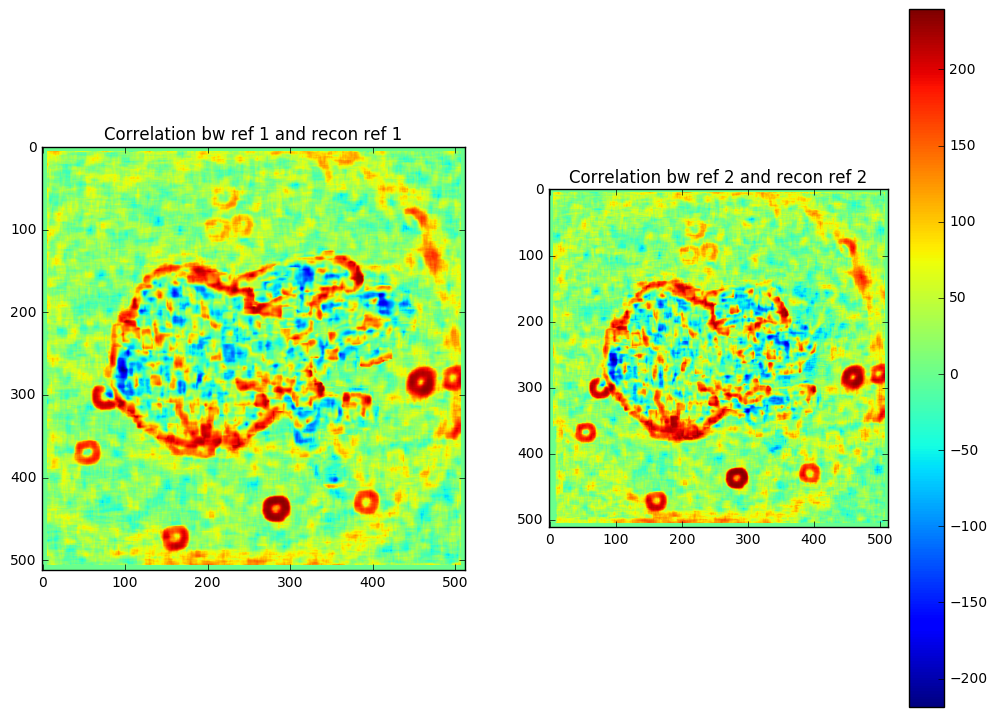

In [19]:
#Plot
f, axes = plt.subplots(1,2)
a=axes[0].imshow(sim1cc*255)
axes[1].imshow(sim2cc*255)
f.colorbar(a)
axes[0].set_title('Correlation bw ref 1 and recon ref 1')
axes[1].set_title('Correlation bw ref 2 and recon ref 2')